In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

t = time.time()

# 0 - Création des fonctions utiles

In [2]:
def sentiment140(stop_words, lemmatization, negation, nb_data):
    file = "train"
    if stop_words:
        file += "_stop"
    if lemmatization:
        file += "_lemm"
    if negation:
        file += "_neg"
    return pd.read_pickle(os.path.join("data", "Sentiment140", file + ".bz2")).sample(nb_data, random_state=1234)

In [3]:
sentiment140(False, False, False, 100)

,sentiment,id,date,query_string,user,text
599410,0,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,0,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,4,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,0,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,4,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
...,...,...,...,...,...,...
878249,4,1685195052,Sat May 02 23:24:34 PDT 2009,NO_QUERY,savage_281,pacquiao ko him out nasty right i won money wu...
905167,4,1695027206,Mon May 04 04:58:16 PDT 2009,NO_QUERY,caityyyyyy,easties you can go there anytime
942103,4,1794502091,Thu May 14 05:57:39 PDT 2009,NO_QUERY,IouliaL,had an awesome dinner last night going to make...
1014340,4,1881419692,Fri May 22 04:36:36 PDT 2009,NO_QUERY,Phai85,launch time teaching from to then pink night x...


In [4]:
class Modelisation():
    def __init__(self, X, y, vectorizer, model, scaling=True):
        X = vectorizer.fit_transform(X)

        if scaling:
            scaler = StandardScaler(with_mean=False)
            X = scaler.fit_transform(X)
        
        if isinstance(model, MultinomialNB):
            X = X.toarray()

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
        sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
        sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        probs = model.predict_proba(X_test)[:, 1]

        metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        self.model = model
        self.probs = probs
        self.metrics_score = metrics_score
    
    def get_data(self):
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def show_conf_matrix(self):
        metrics.plot_confusion_matrix(self.model, self.X_test, self.y_test, cmap='Blues')
        plt.show()

        print(f"Accuracy : {self.metrics_score['accuracy']:.4f}")
        print(f"Balanced accuracy : {self.metrics_score['balanced_accuracy']:.4f}")
        print(f"ROC AUC : {self.metrics_score['roc_auc']:.4f}")

In [5]:
def comparaison(X, y, N, model, scaling=True, show_graph=True):
    """
    Compraison des modèles par rapport à la courbe ROC
    N correspond au nombre de features
    """
    table = []
    
    m = Modelisation(X, y, CountVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, CountVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)

    m = Modelisation(X, y, TfidfVectorizer(max_features = N, ngram_range=(1,2)), model)
    table.append(m.metrics_score)
    
    
    df = pd.DataFrame(table, index=[f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"])
    
    return df

In [6]:
def influence_preprocessing(N, model, show_graph=False, show_table=False):
    tables = []
    for stop_words in [False, True]:
        for lemmatization in [False, True]:
            for negation in [False, True]:
                print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
                df_temp = sentiment140(stop_words, lemmatization, negation, NB_DATA)
                X = df_temp.text.to_list()
                y = df_temp.sentiment.to_list()            
                df_metrics = comparaison(X, y, N, model, show_graph=show_graph)
                if show_table:
                    display(df_metrics)
                df_metrics['stop_words'] = stop_words
                df_metrics['lemmatization'] = lemmatization
                df_metrics['negation'] = negation
                tables.append(df_metrics)
    return pd.concat(tables)

In [7]:
def influence_features(X, y, max_features_list, model, scaling=True):
    table = []
    for max_features in max_features_list:
        m = Modelisation(X, y, CountVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)

        m = Modelisation(X, y, CountVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "CountVectorizer ngram 2"
        table.append(metrics_score)

        m = Modelisation(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(1, 2)), model)
        metrics_score = m.metrics_score
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.show()
    return df

# 1 - Sélection des meilleurs paramètres du modèle Multinomial Naive Bayes

On commence par choisir le nombre de lignes que l'on extrait de la base Sentiment140 sur laquelle on entraîne et évalue notre modèle

In [8]:
NB_DATA = 100000

## 1.1 - Comparaison des méthodes de preprocessing et de feature extraction

In [9]:
df_metrics = influence_preprocessing(500, MultinomialNB())

stop_words: False, lemmatization: False, negation: False
stop_words: False, lemmatization: False, negation: True
stop_words: False, lemmatization: True, negation: False
stop_words: False, lemmatization: True, negation: True
stop_words: True, lemmatization: False, negation: False
stop_words: True, lemmatization: False, negation: True
stop_words: True, lemmatization: True, negation: False
stop_words: True, lemmatization: True, negation: True


In [10]:
df_metrics.sort_values(by="roc_auc", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
TfidfVectorizer 500,0.72580,0.726089,0.804000,False,True,True
TfidfVectorizer 500 ngram 2,0.72645,0.726464,0.803372,False,True,False
TfidfVectorizer 500,0.72280,0.722883,0.798662,False,False,False
TfidfVectorizer 500,0.72125,0.721543,0.798489,False,False,True
CountVectorizer 500,0.72730,0.727496,0.798295,False,True,True
TfidfVectorizer 500 ngram 2,0.72065,0.720670,0.798167,False,False,False
TfidfVectorizer 500,0.72050,0.720510,0.797797,False,True,False
TfidfVectorizer 500 ngram 2,0.72210,0.722141,0.797403,False,True,True
CountVectorizer 500 ngram 2,0.72670,0.726735,0.795712,False,True,False
CountVectorizer 500,0.72200,0.722232,0.791982,False,False,True


In [11]:
df_metrics.sort_values(by="balanced_accuracy", ascending=False)

,accuracy,balanced_accuracy,roc_auc,stop_words,lemmatization,negation
CountVectorizer 500,0.72730,0.727496,0.798295,False,True,True
CountVectorizer 500 ngram 2,0.72670,0.726735,0.795712,False,True,False
TfidfVectorizer 500 ngram 2,0.72645,0.726464,0.803372,False,True,False
TfidfVectorizer 500,0.72580,0.726089,0.804000,False,True,True
TfidfVectorizer 500,0.72280,0.722883,0.798662,False,False,False
CountVectorizer 500,0.72270,0.722760,0.791785,False,False,False
CountVectorizer 500,0.72270,0.722700,0.791818,False,True,False
CountVectorizer 500,0.72200,0.722232,0.791982,False,False,True
TfidfVectorizer 500 ngram 2,0.72210,0.722141,0.797403,False,True,True
CountVectorizer 500 ngram 2,0.72185,0.721863,0.791917,False,False,False


## 1.2 - Comparaison par rapport au nombre de features

In [12]:
NB_DATA = 100000
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION, NB_DATA)

In [13]:
df.head(10)

,sentiment,id,date,query_string,user,text
599410,0,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,0,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,4,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,0,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,4,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,4,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,0,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,4,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,0,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,0,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [14]:
X_1 = df.text.to_list()
y_1 = df.sentiment.to_list()

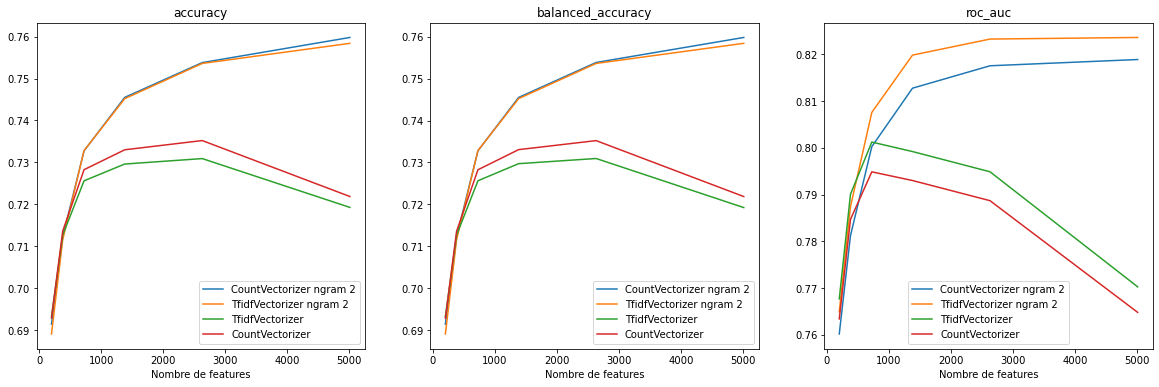

,accuracy,balanced_accuracy,roc_auc,features,method
0,0.69285,0.692875,0.763400,199,CountVectorizer
1,0.69320,0.693296,0.767689,199,TfidfVectorizer
2,0.69140,0.691461,0.760173,199,CountVectorizer ngram 2
3,0.68905,0.689124,0.764935,199,TfidfVectorizer ngram 2
4,0.71360,0.713615,0.784689,380,CountVectorizer
5,0.71265,0.712705,0.790069,380,TfidfVectorizer
6,0.71225,0.712310,0.781227,380,CountVectorizer ngram 2
7,0.71155,0.711644,0.787442,380,TfidfVectorizer ngram 2
8,0.72825,0.728262,0.794865,724,CountVectorizer
9,0.72560,0.725643,0.801236,724,TfidfVectorizer


In [15]:
max_features_list = np.logspace(2.3, 3.7, 6, endpoint=True, dtype=int)
influence_features(X_1, y_1, max_features_list, MultinomialNB())

## 1.3 - GridSearch pour obtenir les meilleures paramètres

On choisit les paramètres au vu des études précédentes

In [16]:
NB_DATA = 100000
STOP_WORDS = False
LEMMATIZATION = True
NEGATION = False
df = sentiment140(STOP_WORDS, LEMMATIZATION, NEGATION, NB_DATA)

In [17]:
X = df.text.to_list()
y = df.sentiment.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

In [18]:
# CountVectorizer
text_clf = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
nb_max_words = len(CountVectorizer().fit(X_train).get_feature_names())

parameters = {'vect__max_features' : np.logspace(2.3, np.log10(nb_max_words), 6, endpoint=True, dtype=int),
          'vect__ngram_range' : [(1,1),(1,2)],
          'clf__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]
}

grid_clf = GridSearchCV(text_clf, parameters, scoring='balanced_accuracy', cv=5)
_ = grid_clf.fit(X_train, y_train)


print('Balanced Accuracy : %.3f' % grid_clf.best_estimator_.score(X_train, y_train))
print('Best Balanced Accuracy Through Grid Search : %.3f' % grid_clf.best_score_)
print('Best Parameters : ', grid_clf.best_params_)

Balanced Accuracy : 0.836
Best Balanced Accuracy Through Grid Search : 0.776
Best Parameters :  {'clf__alpha': 1, 'vect__max_features': 40077, 'vect__ngram_range': (1, 2)}


# 2 - Estimation finale du modèle

On utilise les hyperparamètres optimaux d'après le GridSearch

In [20]:
m = Modelisation(X, y, CountVectorizer(max_features=40077, ngram_range=(1,2)), MultinomialNB(alpha=1))
m.show_conf_matrix()

MemoryError: Unable to allocate 29.9 GiB for an array with shape (100000, 40077) and data type float64

In [ ]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")